In [3]:
!pip install --user pyldavis

     |████████████████████████████████| 1.4 MB 9.0 MB/s eta 0:00:01
  Created wheel for nltk: filename=nltk-3.5-py3-none-any.whl size=1434673 sha256=4932f45a30a99df8b6eb7655fec17681338cc73169ac537ac033b7bae8bc39a0
  Stored in directory: /home/raltman/.cache/pip/wheels/de/5e/42/64abaeca668161c3e2cecc24f864a8fc421e3d07a104fc8a51
Successfully built nltk


# Bag-of-words

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

sns.set()

In [3]:
data = pd.read_csv("data/lemmatized_dataset.tsv", sep='\t')

In [4]:
vec = CountVectorizer(
    stop_words='english',  # Remove common uninformative words
    ngram_range=(1, 2),  # Include bigrams
    min_df=10,  # Remove words that appear in <10 documents
    max_df=0.2  # Remove words that appear in >20% of documents
)
X = vec.fit_transform(data.text)

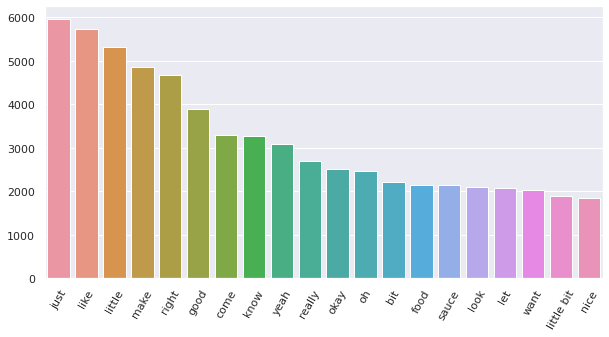

In [5]:
n = 20

values = X.toarray().sum(axis=0)
labels = np.array(vec.get_feature_names())
top_n = values.argsort()[:-n-1:-1]

fig, ax = plt.subplots(figsize=(10,5))
sns.barplot(labels[top_n], values[top_n], ax=ax)
_ = ax.set_xticklabels(labels[top_n], rotation=60)

# Latent Dirichlet Allocation

<img src="imgs/lda1.png">

In [6]:
import numpy as np
from tqdm import tqdm
from textwrap import fill
from scipy.spatial.distance import pdist, squareform
from sklearn.decomposition import LatentDirichletAllocation as LDA
from sklearn.manifold import MDS

tqdm.pandas()

In [16]:
lda = LDA(n_components=5, n_jobs=-1)
X_lda = lda.fit_transform(X)

100%|██████████| 650/650 [00:12<00:00, 51.46it/s]


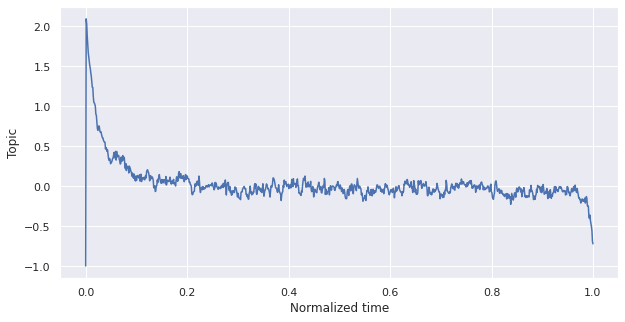

In [17]:
def time_series_topics(group):
    topics = np.zeros_like(times) - 1
    for idx, row in group.iterrows():
        start = row.start / row.duration
        end = row.end / row.duration
        topics[(start<times) & (times<=end)] = row.topic
    return topics

data_topics = data.assign(topic=X_lda.argmax(axis=1))

times = np.linspace(0, 1, int(1e3))
data_topics_ts = data_topics.groupby('name').progress_apply(time_series_topics)

fig, ax = plt.subplots(figsize=(10,5))
sns.lineplot(times, data_topics_ts.mean(), ax=ax)
_ = ax.set_xlabel("Normalized time")
_ = ax.set_ylabel("Topic")

In [18]:
topic_word_probs = lda.components_ / lda.components_.sum(axis=1, keepdims=True)
doc_topic_probs = X_lda / X_lda.sum(axis=1, keepdims=True)

In [19]:
def top_n_topic_docs(n: int = 1):
    top_n = doc_topic_probs.argsort(axis=0)[:-n-1:-1].T
    return np.vectorize(data.text.__getitem__)(top_n)

In [20]:
distance_matrix = squareform(pdist(topic_word_probs, metric='jensenshannon'))
mds = MDS(n_components=2, dissimilarity='precomputed')
X_mds = mds.fit_transform(distance_matrix)

In [21]:
topic_freq = (X_lda.T * X.sum(axis=1)).A.squeeze()
topic_freq /= topic_freq.sum()

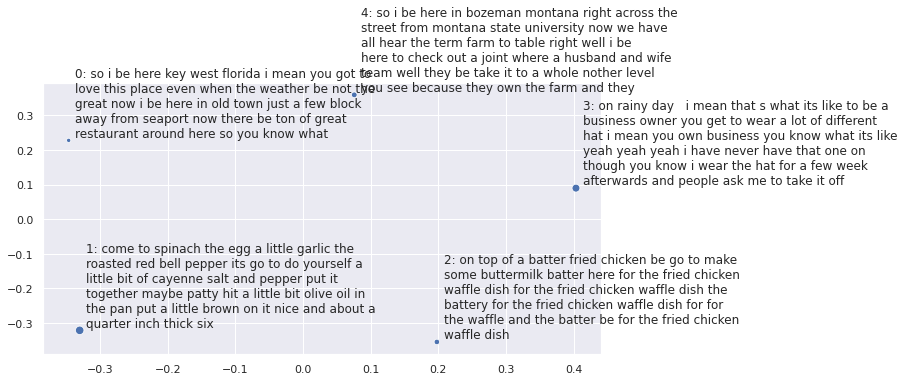

In [22]:
topic_reps = top_n_topic_docs()[:, 0]
fig, ax = plt.subplots(figsize=(10,5))
sns.scatterplot(*X_mds.T, size=1e4*topic_freq, legend=False, ax=ax)
for i, ((x, y), text) in enumerate(zip(X_mds, topic_reps)):
    ax.text(x+.01, y+.01, f"{i}: {fill(text, 50)}")

In [23]:
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()

In [24]:
pyLDAvis.sklearn.prepare(lda, X, vec, mds='mmds', n_jobs=-1)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.194398  0.272202       1        1  24.445741
3     -0.031816 -0.253477       2        1  22.887606
4     -0.238512 -0.095640       3        1  18.397849
2     -0.165794  0.206684       4        1  18.045139
0      0.241724 -0.129769       5        1  16.223665, topic_info=        Term         Freq        Total Category  logprob  loglift
2392    just  5927.000000  5927.000000  Default  30.0000  30.0000
2794  little  5237.000000  5237.000000  Default  29.0000  29.0000
2703    like  5673.000000  5673.000000  Default  28.0000  28.0000
4021  really  2619.000000  2619.000000  Default  27.0000  27.0000
2877    look  2085.000000  2085.000000  Default  26.0000  26.0000
...      ...          ...          ...      ...      ...      ...
3224     mix   304.082286   720.462116   Topic5  -5.3357   0.9561
319      bit   388.088082  2179.736365   Topic5  -5.0918   0.0930
5265     use   316.465385  1077.276096   Topic5  -5.2958   0.5937
2703    like   379.697993  5673.868172   Topic5  -5.1136  -0.8856
1701   fresh   282.788981  1185.982966   Topic5  -5.4083   0.3851

[357 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
21        1  0.998715       add
21        5  0.000844       add
51        5  0.995597       ago
91        3  0.993384  americas
96        5  0.995722   angeles
...     ...       ...       ...
5554      2  0.005128       yes
5554      3  0.018804       yes
5554      4  0.943605       yes
5565      4  0.994185   yes sir
5576      2  0.995238      york

[657 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 4, 5, 3, 1])